In [115]:
import sqlite3
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

In [17]:
def query_sqlite(sql_query, db='/home/yunyi/ethereum.db'):
    # rtype: list of tuples (a,b) sorted by a
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute(sql_query)
    res=sorted(c.fetchall())
    conn.close()
    return res

In [18]:
res_isError = query_sqlite('SELECT timeStamp, count(*) FROM transactions WHERE isError==1 GROUP BY blockNumber')
res_txns = query_sqlite('SELECT timeStamp, count(*) FROM transactions GROUP BY blockNumber')
res_creation = query_sqlite('SELECT timeStamp, count(*) \
                            FROM transactions \
                            WHERE contractAddress like "0x%" \
                            GROUP BY timeStamp')

In [21]:
# results look like...
print(res_isError[:5])
print(res_txns[:5])
print(res_creation[:5])

[(1438982400, 1), (1438982525, 1), (1438984016, 1), (1438986071, 1), (1438989286, 1)]
[(1438973337, 1), (1438980507, 1), (1438980648, 1), (1438981410, 1), (1438982400, 1)]
[(1438973337, 1), (1438980507, 1), (1438981410, 1), (1439210480, 1), (1439249180, 1)]


In [123]:
def plot_timeSeries_Data_with_2yscales(res_dic, res_dic1, price_df, title):
    
    # prepare the txn line
    df = pd.DataFrame(sorted(res_dic))
    df.columns = ['timeStamp', 'Count']
    df.timeStamp = pd.to_datetime(df.timeStamp, unit="s")
    a = df.resample('m', on='timeStamp')['Count'].sum() # Series
    u = a.index.tolist()
    v = a.tolist()
    print("total txn: ", sum(a.dropna().tolist()))
    
    # prepare the isError line
    df1 = pd.DataFrame(sorted(res_dic1))
    df1.columns = ['timeStamp', 'Count']
    df1.timeStamp = pd.to_datetime(df1.timeStamp, unit="s")
    a1 = df1.resample('m', on='timeStamp')['Count'].sum() # Series
    u1 = a1.index.tolist()
    v1 = a1.tolist()
    print("txn w/ error: ", sum(a1.dropna().tolist()))

    # prepare the price line
    price_df.UnixTimeStamp = pd.to_datetime(price_df.UnixTimeStamp, unit="s")
    a2 = price_df.resample('m', on='UnixTimeStamp')['Value'].mean() # monthly average
    u2 = a2.index.tolist()
    v2 = a2.tolist()
    
    # plotting...
    # the price (in USD) is much smaller in scale compared to count
    fig, ax1 = plt.subplots(figsize=(10,6))
    
   
    #ax1 = host.twinx()
    ax1.plot(u[:-1], v[:-1], "go-", label='total txn') # the last month is incomplete, so stripped
    ax1.plot(u1[:-1], v1[:-1], "ro-", label='txn w/ error') # the last month is incomplete, so stripped
    ax1.set_ylabel('Monthly Count')
    ax1.yaxis.set_label_position('left')
    ax1.yaxis.set_ticks_position('left')
    
    ax2 = ax1.twinx()
    ax2.plot(u2, v2, "yo-", label='Ether monthly price (USD)')
    ax2.set_ylabel('USD')
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.set_ticks_position('right')


    fig.tight_layout()
    plt.title(title)
    
    # touch up the x-labels
    plt.gcf().autofmt_xdate()
    
    
    # add vertical line for hard fork
    hard_forks = [1441661589, 1457981393, 1469020840, 1476796771, 1479831344, 1508131331]
    fork_names = ['Frontier Thawing (Planned)', 'Homestead (Planned)', 'Dao Fork', 'EIP-150 Hard Fork', 'Spurious Dragon', 'Byzantium (Planned)']
    line_format = ['g', 'c', 'k', 'y', 'w', 'm']
    i = 0
    for z in hard_forks:
        xc = pd.to_datetime(z, unit="s")
        plt.axvline(x=xc, linestyle='--', color=line_format[i], label=fork_names[i])
        i += 1

    # two fake lines for legend (somehow the lines just don't show in one legend otherwise)
    plt.plot(np.nan, "go-", label='total txn')
    plt.plot(np.nan, "ro-", label='txn w/ error')
    plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
       ncol=1, shadow=False, title="Legend", fancybox=True)

    plt.show()

In [54]:
price = pd.read_csv('./export-EtherPrice.csv')

In [55]:
price.head()

,Date(UTC),UnixTimeStamp,Value
0,7/30/2015,1438214400,0.0
1,7/31/2015,1438300800,0.0
2,8/1/2015,1438387200,0.0
3,8/2/2015,1438473600,0.0
4,8/3/2015,1438560000,0.0


total txn:  36203106.0
txn w/ error:  1750740.0


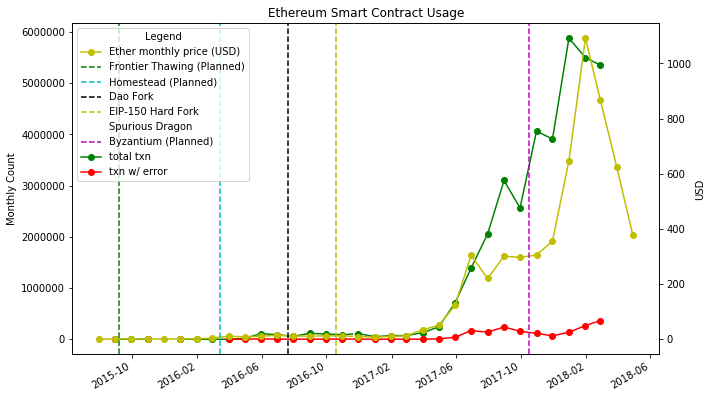

In [124]:
plot_timeSeries_Data_with_2yscales(res_txns, res_isError, price, title='Ethereum Smart Contract Usage')

In [57]:
def plot_single_data(res_dict, title):
    df = pd.DataFrame(sorted(res_dict))
    df.columns = ['timeStamp', 'Count']
    df.timeStamp = pd.to_datetime(df.timeStamp, unit="s")
    a = df.resample('m', on='timeStamp')['Count'].sum() # Series
    u = a.index.tolist()
    v = a.tolist()
    
    plt.figure(figsize=(8,5))
    print(sum(a.dropna().tolist()))
    
    plt.plot(u[:-1], v[:-1], "o-")
    plt.ylabel('Monthly Count')
    plt.title(title)
    plt.gcf().autofmt_xdate()
    plt.show()

14637.0


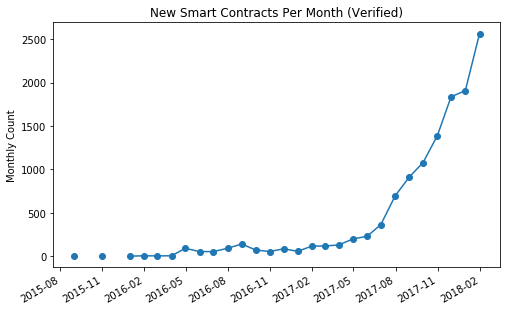

In [58]:
plot_single_data(res_creation, "New Smart Contracts Per Month (Verified)")